<a href="https://colab.research.google.com/github/CupOfDim/neuron/blob/main/Find5SameImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from tensorflow.keras import applications
import tensorflow as tf
from tensorflow.keras.models import save_model
import tensorflow.keras.layers as L
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm
from skimage import io
import glob

In [5]:
path = "/content/drive/MyDrive/dataset"
filelist = [] 
for root, dirs, files in os.walk(path): 
    for file in files: 
        #append the file name to the list 
        filelist.append(os.path.join(root,file))
  

In [15]:
print(filelist[0])

/content/drive/MyDrive/dataset/0203.png


In [6]:
def image2array(filelist):
    image_array = []
    for image in filelist[:200]:
        img = io.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image_array.append(img)
    image_array = np.array(image_array)
    image_array = image_array.reshape(image_array.shape[0], 224, 224, 3)
    image_array = image_array.astype('float32')
    image_array /= 255
    return np.array(image_array)

train_data = image2array(filelist)
print("Length of training dataset:", train_data.shape)

Length of training dataset: (200, 224, 224, 3)


In [10]:
IMG_SHAPE = train_data.shape[1:]
def build_autoencoder(image_shape, code_size):
  H,W,C = image_shape
  # encoder
  encoder = tf.keras.models.Sequential()
  encoder.add(L.InputLayer(image_shape))
  encoder.add(L.Conv2D(filters=32,kernel_size=[3,3], activation="relu",padding="same"))
  encoder.add(L.MaxPooling2D(pool_size=(2,2)))
  encoder.add(L.Conv2D(filters=64,kernel_size=[3,3], activation="relu",padding="same"))
  encoder.add(L.MaxPooling2D(pool_size=(2,2)))
  encoder.add(L.Conv2D(filters=128,kernel_size=[3,3], activation="relu",padding="same"))
  encoder.add(L.MaxPooling2D(pool_size=(2,2)))
  encoder.add(L.Conv2D(filters=256,kernel_size=[3,3], activation="relu",padding="same"))
  encoder.add(L.MaxPooling2D(pool_size=(2,2)))
  encoder.add(L.Flatten())
  encoder.add(L.Dense(code_size))

  # decoder
  decoder = tf.keras.models.Sequential()
  decoder.add(L.InputLayer(code_size))
  decoder.add(L.Dense(14*14*256))
  decoder.add(L.Reshape((14,14,256)))
  decoder.add(L.Conv2DTranspose(filters=128,kernel_size=[3,3], activation="relu",padding="same",strides=2))
  decoder.add(L.Conv2DTranspose(filters=64,kernel_size=[3,3], activation="relu",padding="same",strides=2))
  decoder.add(L.Conv2DTranspose(filters=32,kernel_size=[3,3], activation="relu",padding="same",strides=2))
  decoder.add(L.Conv2DTranspose(filters=3,kernel_size=[3,3], activation=None,padding="same",strides=2))

  return encoder, decoder

encoder, decoder = build_autoencoder(IMG_SHAPE, 32)
encoder.summary()
decoder.summary()





Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 28, 28, 128)     

In [14]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')
autoencoder.fit(x=train_data, y=train_data, epochs=10, verbose=1)

Epoch 1/10
7/7 [==============================] - 46s 6s/step - loss: 0.3575
Epoch 2/10
7/7 [==============================] - 39s 6s/step - loss: 0.2155
Epoch 3/10
7/7 [==============================] - 55s 7s/step - loss: 0.1297
Epoch 4/10
7/7 [==============================] - 50s 7s/step - loss: 0.0892
Epoch 5/10
7/7 [==============================] - 50s 7s/step - loss: 0.0750
Epoch 6/10
7/7 [==============================] - 42s 6s/step - loss: 0.0657
Epoch 7/10
7/7 [==============================] - 44s 6s/step - loss: 0.0627
Epoch 8/10
7/7 [==============================] - 49s 7s/step - loss: 0.0596
Epoch 9/10
7/7 [==============================] - 47s 6s/step - loss: 0.0587
Epoch 10/10
7/7 [==============================] - 42s 6s/step - loss: 0.0579


In [17]:
images = train_data
codes = encoder.predict(images)

7/7 [==============================] - 15s 2s/step


In [29]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(metric='euclidean')

In [30]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"
    code = encoder.predict(image[None])    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    return distances,images[idx]
def show_similar(image):
    distances,neighbors = get_similar(image,n_neighbors=3)
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

1/1 [==============================] - 0s 129ms/step


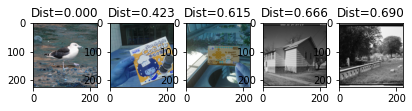

In [55]:
def get_similar(image, n_neighbors=5):
  assert image.ndim == 3
  code = encoder.predict(image[None])
  (dist,), (ind,) = nei_clf.kneighbors(code, n_neighbors=n_neighbors)
  return dist, images[ind]

def show_similar(image):
  dist, neighbors = get_similar(image, n_neighbors=5)
  plt.figure(figsize=[8,7])
  plt.subplot(1,4,1)
  plt.imshow(image)
  plt.title("Original image")

  for i in range(5):
    plt.subplot(1,6,i+2)
    plt.imshow(neighbors[i])
    plt.title("Dist=%.3f"%dist[i])
  plt.show()
show_similar(train_data[90])
